In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin

from typing import List

## load & split

In [2]:
purchases = pd.read_csv('retail_train.csv')
purchases.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [3]:
# train/test split
test_size_weeks = 3

train = purchases[purchases['week_no'] < purchases['week_no'].max() - test_size_weeks].copy()
test = purchases[purchases['week_no'] >= purchases['week_no'].max() - test_size_weeks].copy()

In [4]:
# products = pd.read_csv('product.csv')
# products.head(3)

In [5]:
# prepare result DataFrame
true_values = test.groupby('user_id')['item_id'].unique().reset_index()
true_values.columns=['user_id', 'actual']
true_values.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Used functions

In [6]:
# Топ популярных товаров
def popularity_measure(source, fields: List[str], k=5000, beta: List[float] = None, add_target=None, scaler=None):
    """ Расчет оценки важности товара в покупке и отбор топ K наиболее популярных товаров
    :param source - исходные данные
    :param fields - признаки, по которым измеряется мера важности товара
    :param k - количество товаров, отбираемых в топ
    :param beta - множители значимости для каждого признака в оценке
    :param add_target - название финального признака. Признак не добавляется, если target = None
    :param scaler - класс масштабирования данных
    """
    b = [1.] * len(fields) if beta is None else np.array(beta)
    assert len(fields) == len(b), '`fields` and `beta` dimensions must equal'
    assert issubclass(StandardScaler, TransformerMixin) or scaler is None, 'scaler must be a subclass of TransformerMixin'
    _df = source[['item_id']].copy()
    prepared = scaler().fit_transform(source[fields]) * b if scaler else source[fields] * b
    values = np.linalg.norm(prepared, ord=2, axis=1)
    _df['popularity'] = values
    if add_target:
        source.loc[:, add_target] = values
    popularity = _df.groupby('item_id')['popularity'].sum()
    return popularity.sort_values(ascending=False).head(k).index.tolist()

In [7]:
def check_model(uim, mdl_params, rec_params, res, ttl='als'):
    """
    :param uim: user-item matrix
    :param mdl_params: model init parameters
    :param rec_params: recommendation parameters
    :param res: true values, including user_id
    :param ttl: model title
    :return: predicted values (DataFrame)
    """
    mdl = AlternatingLeastSquares(**mdl_params)
    mdl.fit(uim.T, show_progress=False)
    res[ttl] = res['user_id'].apply(partial(recommender, mdl=mdl, params=rec_params))
    return res

In [8]:
# предсказатель-интерпретатор
def recommender(user_id, mdl, params):
    uid = userid_to_id.get(user_id, None)
    if uid is None:
        return list()
    rec_score = mdl.recommend(userid_to_id[user_id], **params)
    return [id_to_itemid[rec[0]] for rec in rec_score]

In [9]:
# метрики
def precision_at_k(recommended_list, bought_list, k=5):
    flags = np.isin(bought_list, recommended_list[:k])
    return flags.sum() / k

def ap_k(recommended_list, bought_list, k=5):
    flags = np.isin(recommended_list, bought_list)
    if sum(flags) == 0:
        return 0

    func = partial(precision_at_k, recommended_list, bought_list)
    rel_items = np.arange(1, k + 1)[flags[:k]]
    return np.sum(list(map(func, rel_items))) / flags.sum()

In [10]:
# сериализация расчета метрики
def calc_metric(metric_func, source: pd.DataFrame):
    """ Подсчет метрики
    :param metric_func - функция измерения метрики. Первый аргумент - рекомендации, второй - актуальные значения
    :param source - данные для подсчета метрики
    """
    def metric_wrapper(pred, act):
        return metric_func(pred, act) if len(pred) != 0 else 0

    metric = pd.DataFrame()
    for col in source.columns:
        if col == 'user_id':
            metric[col] = source[col]
        elif col == 'actual':
            continue
        else:
            metric[col] = source[[col, 'actual']].apply(lambda row: metric_wrapper(*row.values), axis=1)
    return metric

In [45]:
def compare_metrics(res, saveto=None):
    pr_at_k = calc_metric(partial(precision_at_k, k=5), res)
    ap_at_k = calc_metric(lambda pred, act: ap_k(pred, act, k=min(5, len(pred))), res)
    smr = pd.DataFrame([pr_at_k.mean(), ap_at_k.mean()], index=['precision@k', 'map@k']).drop(columns='user_id')
    if saveto:
        smr.T.to_csv(saveto)
    return smr

In [12]:
def plot_weight_curve(data: pd.Series, p1=False):
    """ Построение графиков весов """
    _val = data.sort_values(ascending=False).values
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(f'Weights curve for {data.name}')
    ax[0].set_title('clean')
    ax[0].plot(_val)
    ax[1].set_title('log-scaled')
    ax[1].plot(np.log1p(_val) if p1 else np.log(_val))
    plt.show()

In [36]:
def apply_weights(uim, wl, axis, top):
    assert len(wl) == len(axis), 'weights and axis lists must be same-dimensional'
    res_mat = []
    for ax, w in zip(axis, wl):
        if ax in [1, 'u', 'user']:
            mat = csr_matrix((uim.T * w).T).tocsr()
        elif ax in [0, 'i', 'item']:
            w = w[w.index.isin(top)]
            w[-1] = 1
            mat = csr_matrix(uim * w).tocsr()
        else:
            mat = csr_matrix(uim).tocsr()
        res_mat.append(mat)
    return res_mat

## Мысли вслух

## Baseline

In [47]:
%%time
# стандартный топ5000 по кол-ву проданных единиц
top5k = popularity_measure(train, ['quantity'], k=5000, add_target='popularity')
top5k[:7]

CPU times: user 239 ms, sys: 196 ms, total: 435 ms
Wall time: 1.14 s


[6534178, 6533889, 6534166, 6544236, 1404121, 397896, 1426702]

In [48]:
# %%time
# # берем топ5000 по оценке популярности товара
# top5k = popularity_measure(train, ['quantity', 'sales_value'], beta=[1., 1.], k=5000, add_target='popularity', scaler=StandardScaler)
# top5k[:7]

In [49]:
# обработка товаров не из топа
top_train = train.copy()
top_train.loc[~top_train['item_id'].isin(top5k), 'item_id'] = -1     # товары не из топ5000 превращаем в один товар
top_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,popularity
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.0


In [50]:
# подготовка обучающих данных: составление таблицы user-item на основе популярности товара для пользователя
user_item_matrix = pd.pivot_table(top_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='popularity',
                                  aggfunc='sum',
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float)

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [51]:
user_item_matrix.head(3)

item_id,-1,202291,397896,420647,480014,545926,707683,731106,818980,819063,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,268.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# remap dictionaries
id_to_itemid = dict(enumerate(user_item_matrix.columns.values))
id_to_userid = dict(enumerate(user_item_matrix.index.values))

itemid_to_id = {v: k for k, v in id_to_itemid.items()}
userid_to_id = {v: k for k, v in id_to_userid.items()}

In [53]:
# подготовка параметров обучения модели и параметров предсказателя
model_params = {'factors': 44,
                'regularization': 0.001,
                'iterations': 15,
                'calculate_training_loss': True,
                'use_gpu': False,
                'random_state': 23}

recommender_params = {
    'user_items': sparse_user_item,
    'N': 5, # кол-во рекомендаций
    'filter_already_liked_items': False,
    'filter_items': [itemid_to_id[-1]],
    'recalculate_user': True
}

In [54]:
%%time
# обучение
result = check_model(sparse_user_item, model_params, recommender_params, true_values.copy(), 'als_baseline')

CPU times: user 2min 26s, sys: 1min 51s, total: 4min 18s
Wall time: 35.5 s


In [55]:
compare_metrics(result)

,als_baseline
precision@k,0.167091
map@k,0.290147


## Взвешивание

Взвешивание применяется на обучающие данные *до обучения* модели. Таким образом, можно рассматривать его как часть этапа feature engineerin'а.
А собственно, вопрос подхода к обработке обучающих данных - это вопрос творческий.
В данной задаче ключевых моментов можно выделить три:
1) способ отбора топа товаров
2) оценка весов товаров
3) оценка весов покупателей

Взвешивать можно и пользователей, и товары:
- При взвешивании пользователей строки умножаются на вес пользователя
- При взвешивании товаров столбцы умножаются на вес товара

#### tf-idf / bm25

In [56]:
%%time
result = check_model(csr_matrix(tfidf_weight(user_item_matrix.T).T).tocsr(), model_params, recommender_params, result, 'als_tf-idf')
result = check_model(csr_matrix(bm25_weight(user_item_matrix.T).T).tocsr(), model_params, recommender_params, result, 'als_bm25')

CPU times: user 5min 56s, sys: 4min 22s, total: 10min 19s
Wall time: 1min 34s


### оценка весов товаров

#### количество чеков, в которых есть товар

In [57]:
item_basket_count = train.groupby('item_id')['basket_id'].count().rename('item_basket_count')
item_basket_count[item_basket_count.index.isin(top5k)].sort_values(ascending=False).head(3)

item_id
1082185    26127
6534178    17545
1029743    12737
Name: item_basket_count, dtype: int64

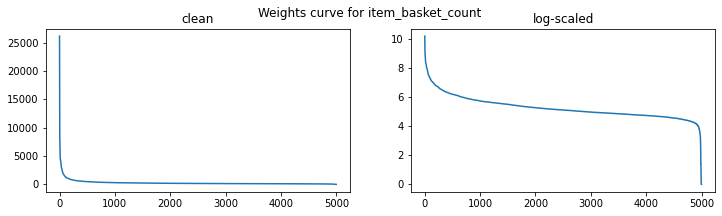

In [58]:
plot_weight_curve(item_basket_count[item_basket_count.index.isin(top5k)])

#### количество дней, когда товар был куплен

In [59]:
sell_days = train.groupby('item_id')['day'].nunique().rename('sell_days')
sell_days[sell_days.index.isin(top5k)].sort_values(ascending=False).head(3)

item_id
1029743    633
1082185    633
981760     630
Name: sell_days, dtype: int64

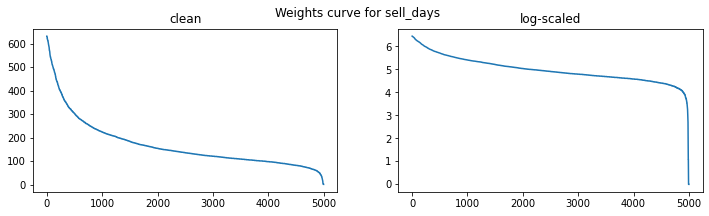

In [60]:
plot_weight_curve(sell_days[sell_days.index.isin(top5k)])

Заметим, что товар 1029743 по кол-ву проданных единиц можно счесть крайне непопулярным. Однако по встречаемости в чеках он на 3-ем месте, а по дневной продаваемости так вообще на 1ом. А самый популярный по кол-ву товар (6534178) покупали только 643 дня из 663 (15ое место, по данным всего датасета).

### оценка весов покупателей

* кол-во чеков на юзера (больше чеков => чаще покупает => больше вес)
* кол-во дней, когда юзер совершал покупки
* средняя сумма чека для каждого юзера (чем больше сумма, тем весомее его выбор - звучит не совсем логично, но попробовать можно)

#### количество чеков каждого покупателя

In [61]:
# кол-во чеков на юзера
user_basket_count = train.groupby('user_id')['basket_id'].nunique().rename('user_basket_count')
user_basket_count.sort_values(ascending=False).head()

user_id
2337    1180
1510    1175
900     1082
1795    1009
2459     949
Name: user_basket_count, dtype: int64

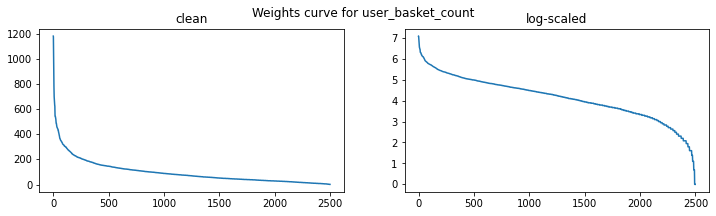

In [62]:
plot_weight_curve(user_basket_count)

#### количество дней, когда покупатель совершал покупки

In [63]:
buy_days = train.groupby('user_id')['day'].nunique().rename('buy_days')
buy_days.sort_values(ascending=False).head()

user_id
900     455
1510    449
1795    441
2459    433
2337    418
Name: buy_days, dtype: int64

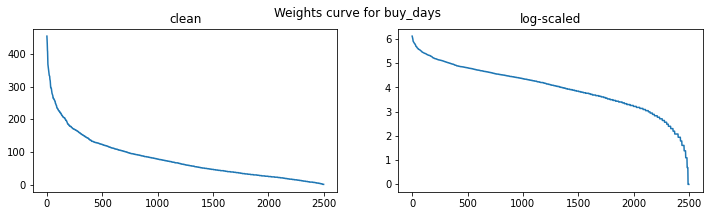

In [64]:
plot_weight_curve(buy_days)

#### средняя сумма чека каждого покупателя

In [65]:
# mbv = mean basket value
feat = train.groupby(['user_id', 'basket_id'])['sales_value'].sum()
mbv_per_user = feat.reset_index().groupby('user_id')['sales_value'].mean().rename('mbv_per_user')
mbv_per_user.sort_values(ascending=False).head()
# то же самое, но по-другому
# train.groupby('user_id')['sales_value'].sum() / train.groupby('user_id')['basket_id'].nunique()

user_id
1899    164.815968
2042    160.822222
973     157.014133
1900    146.932917
1574    133.144444
Name: mbv_per_user, dtype: float64

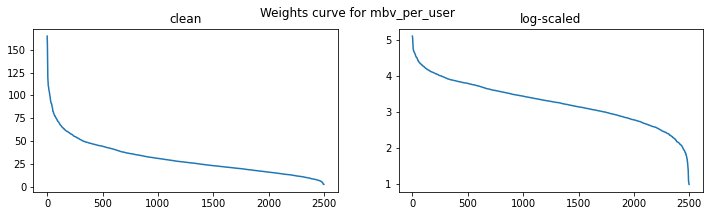

In [66]:
plot_weight_curve(mbv_per_user)

#### комбинированные веса

#### метрики по весам

In [67]:
%%time
# собираем списки взвешенных user-item матриц
weights_data = [item_basket_count, np.log(item_basket_count),
                sell_days, np.log(sell_days),
                user_basket_count, np.log(user_basket_count),
                buy_days, np.log(buy_days),
                mbv_per_user, np.log(mbv_per_user)]
weights_axis = ['item', 'item',
                'item', 'item',
                'user', 'user',
                'user', 'user',
                'user', 'user']
weights_title = ['item basket', 'item basket log',
                 'sell days', 'sell days log',
                 'user basket', 'user basket log',
                 'buy days', 'buy days log',
                 'mbv per user', 'mbv per user log']
uim_weighted = apply_weights(user_item_matrix, weights_data, weights_axis, top5k)

CPU times: user 1.71 s, sys: 160 ms, total: 1.87 s
Wall time: 1.87 s


In [68]:
%%time
for matrix, title in zip(uim_weighted, weights_title):
    check_model(matrix, model_params, recommender_params, result, title)

CPU times: user 23min 54s, sys: 18min 15s, total: 42min 9s
Wall time: 5min 42s


In [69]:
compare_metrics(result, 'weighted_metrics_default.csv')

,als_baseline,als_tf-idf,als_bm25,item basket,item basket log,sell days,sell days log,user basket,user basket log,buy days,buy days log,mbv per user,mbv per user log
precision@k,0.167091,0.180118,0.201469,0.089030,0.184525,0.144368,0.185015,0.204603,0.186876,0.205191,0.185602,0.206268,0.180411
map@k,0.290147,0.319193,0.357718,0.228967,0.341344,0.287191,0.340198,0.397343,0.349447,0.398929,0.346871,0.391246,0.331683
